In [0]:
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

import numpy as np
import pandas as pd
import category_encoders as ce
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot, PDPIsolate
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import plotly.express as px
import shap

### Attribute Information:

The dataset consists of 10 numerical and 8 categorical attributes.
The **'Revenue'** attribute can be used as the **class label**.


**"Administrative"**, **"Administrative Duration"**, **"Informational"**, "Informational Duration", "Product Related" and "Product Related Duration" represent the number of different types of pages visited by the visitor in that session and total time spent in each of these page categories. The values of these features are derived from the URL information of the pages visited by the user and updated in real time when a user takes an action, e.g. moving from one page to another. 

The **"Bounce Rate"**, **"Exit Rate"** and "Page Value" features represent the metrics measured by "Google Analytics" for each page in the e-commerce site. 

The value of **"Bounce Rate"** feature for a web page refers to the percentage of visitors who enter the site from that page and then leave ("bounce") without triggering any other requests to the analytics server during that session. 

The value of **"Exit Rate"** feature for a specific web page is calculated as for all pageviews to the page, the percentage that were the last in the session. 

The **"Page Value"** feature represents the average value for a web page that a user visited before completing an e-commerce transaction. 

The **"Special Day"** feature indicates the closeness of the site visiting time to a specific special day (e.g. Mother’s Day, Valentine's Day) in which the sessions are more likely to be finalized with transaction. The value of this attribute is determined by considering the dynamics of e-commerce such as the duration between the order date and delivery date. For example, for Valentina’s day, this value takes a nonzero value between February 2 and February 12, zero before and after this date unless it is close to another special day, and its maximum value of 1 on February 8. 

The dataset also includes operating system, browser, region, traffic type, visitor type as returning or new visitor, a Boolean value indicating whether the date of the visit is weekend, and month of the year.

In [0]:
# https://www.kaggle.com/roshansharma/online-shoppers-intention
df = pd.read_csv("online_shoppers_intention.csv").dropna()
df["Revenue"] = df["Revenue"].astype(int)
print(f"Rows:{df.shape[0]}\nColumns:{df.shape[1]}\n\n---NaN Count---\n{df.isnull().sum()}")
df.head()

Rows:12316
Columns:18

---NaN Count---
Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,0
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,0
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,0
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,0
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,0


In [0]:
from sklearn.metrics import roc_auc_score

In [0]:
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

training, test = train_test_split(df)
train, val = train_test_split(training)
target = "Revenue"

x_train = train.drop(columns=target)
y_train = train[target]

x_val = val.drop(columns=target)
y_val = val[target]

x_test = val.drop(columns=target)
y_test = val[target]

gb_merge = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler(),
    SimpleImputer(strategy='median'), 
    XGBClassifier(
        n_estimators=1000, 
        n_jobs=-1,
        max_depth=10,
        learning_rate=0.002,
        gamma=0.2
    )
)

gb_merge.fit(x_train, y_train)
y_pred = gb_merge.predict(x_val)
print('Accuracy', accuracy_score(y_val, y_pred))

Accuracy 0.8939393939393939


In [0]:
y_pred_proba = gb_merge.predict_proba(x_val)
print(f"---ROC/AUC---\n{roc_auc_score(y_val, y_pred_proba[:,-1])}")

---ROC/AUC---
0.9308409983793968


In [0]:
#MSB
df["Revenue"].value_counts(normalize=True)

0    0.84508
1    0.15492
Name: Revenue, dtype: float64

X_train_merge shape after encoding (6927, 17)


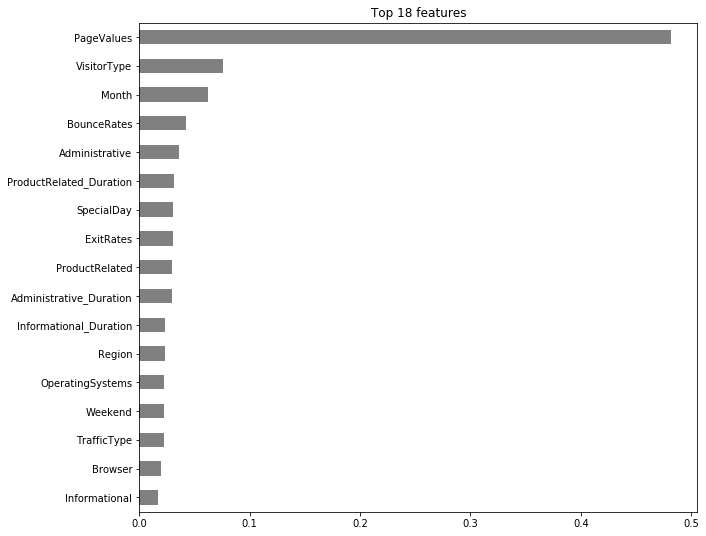

In [0]:
encoder_merge = gb_merge.named_steps['ordinalencoder']
encoded_merge = encoder_merge.transform(x_train)
print('X_train_merge shape after encoding', encoded_merge.shape)

model_merge = gb_merge.named_steps['xgbclassifier']
importances_merge = pd.Series(model_merge.feature_importances_, encoded_merge.columns)

n = 18
plt.figure(figsize=(10, n/2))
plt.title(f'Top {n} features')
importances_merge.sort_values()[-n:].plot.barh(color='grey');

In [0]:
import eli5
from eli5.sklearn import PermutationImportance

processor = make_pipeline(
    ce.OrdinalEncoder(),
    # StandardScaler(),
    SimpleImputer(strategy='median')
)

model = XGBClassifier(n_estimators=1000, 
                      n_jobs=-1,
                      max_depth=10,
                      learning_rate=0.002,
                      gamma=0.2)

X_train_processed_merge = processor.fit_transform(x_train)
X_val_processed_merge = processor.transform(x_val)

model.fit(X_train_processed_merge, y_train)

permuter = PermutationImportance(
    model, 
    scoring='accuracy', 
    n_iter=5, 
    random_state=42
)

permuter.fit(X_val_processed_merge, y_val)

eli5.show_weights(
    permuter,
    top=None,
    feature_names = x_val.columns.tolist()
)

Weight,Feature
0.1622 ± 0.0101,PageValues
0.0074 ± 0.0039,Month
0.0069 ± 0.0021,ProductRelated_Duration
0.0057 ± 0.0069,ExitRates
0.0038 ± 0.0050,BounceRates
0.0007 ± 0.0054,Administrative_Duration
0.0002 ± 0.0014,Weekend
0.0002 ± 0.0024,Administrative
-0.0001 ± 0.0034,VisitorType
-0.0003 ± 0.0004,SpecialDay


(0.0001, 1)

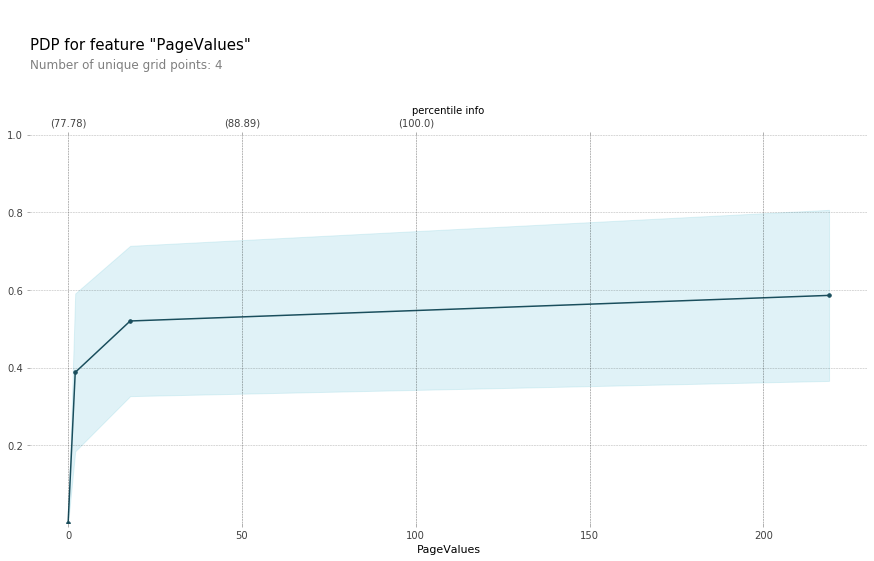

In [0]:
feature = "PageValues"

isolated = pdp_isolate(
    model = gb_merge,
    dataset = x_val, #Must use dataset that doesnt have NaN value present
    model_features = list(x_val.columns),
    feature = feature
)

pdp_plot(isolated,
         feature_name=feature, 
         frac_to_plot=50,
        show_percentile=True)
plt.ylim(0.0001,1)

(<Figure size 1080x684 with 3 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f298159d128>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f298148e048>})

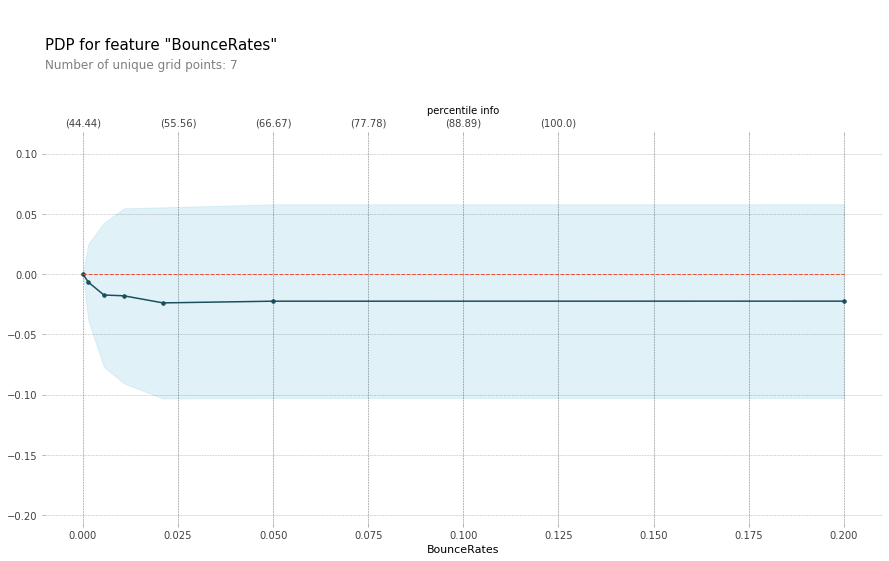

In [0]:
feature = "BounceRates"

isolated = pdp_isolate(
    model = gb_merge,
    dataset = x_val, #Must use dataset that doesnt have NaN value present
    model_features = list(x_val.columns),
    feature = feature
)

pdp_plot(isolated,
         feature_name=feature, 
         frac_to_plot=50,
        show_percentile=True)

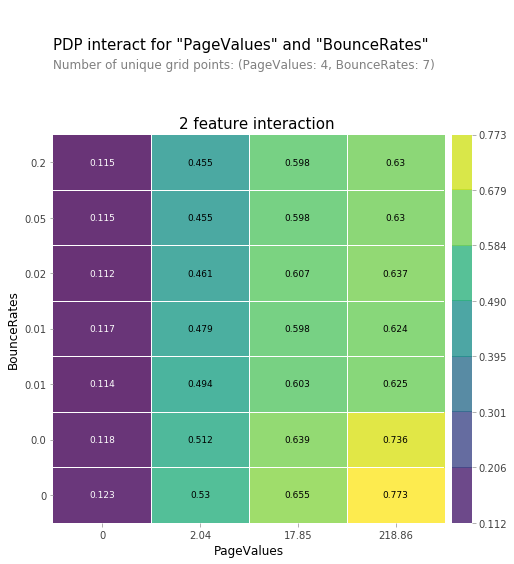

In [0]:
features = ['PageValues', 'BounceRates']

interaction = pdp_interact(
    model=gb_merge,
    dataset=x_val,
    model_features=x_val.columns,
    features=features,
)


fig, axes = pdp_interact_plot(interaction, feature_names=features, plot_type='grid')
plt.title('2 feature interaction', position=(-10,1), fontsize=15);

In [0]:
df[df["PageValues"] > 0].shape

(2730, 18)

In [0]:
import shap

row = x_test.loc[[5965]]

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row,
    link="logit"
)

In [0]:
y_test.loc[[5965]]

5965    1
Name: Revenue, dtype: int64

In [0]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba[:,-1])

# See the results in a table
pd.DataFrame({
    'False Positive Rate': fpr, 
    'True Positive Rate': tpr, 
    'Threshold': thresholds
})

,False Positive Rate,True Positive Rate,Threshold
0,0.000000,0.000000,1.920725
1,0.000000,0.002653,0.920725
2,0.000000,0.079576,0.892362
3,0.000517,0.079576,0.891963
4,0.000517,0.100796,0.888730
...,...,...,...
422,0.662700,0.997347,0.071695
423,0.664252,0.997347,0.070843
424,0.953440,1.000000,0.070796
425,0.954992,1.000000,0.070595


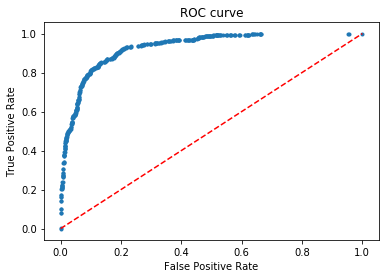

In [0]:
# See the results on a plot. 
# This is the "Receiver Operating Characteristic" curve
plt.scatter(fpr, tpr, marker=".")
plt.plot([0,1], [0,1], linestyle="--", c="r")
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

### Grid Search CV

In [0]:
from sklearn.model_selection import RandomizedSearchCV
import random

In [0]:
pipe = make_pipeline(
    ce.OneHotEncoder(),
    StandardScaler(),
    SimpleImputer(), 
    XGBClassifier()
)

pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_val)
print('Accuracy', accuracy_score(y_val, y_pred))

Accuracy 0.9


In [0]:
%%time
from sklearn.pipeline import Pipeline

model = XGBClassifier()

pipe = make_pipeline(
    ce.OneHotEncoder(),
    StandardScaler(),
    SimpleImputer(),
)

pipeline = Pipeline([("pipe",pipe), 
                    ("clf", model)])

param_grid = {
    "pipe__onehotencoder__drop_invariant": [True, False],
    "pipe__simpleimputer__strategy": ["mean", "median", "most_frequent"],
    "clf__model__n_estimators": [100,200,300,400,500,600,700],
    "clf__model__max_depth": [random.randint(1,12)],
    "clf__model__learning_rate": [0.2, 0.002, 0.0002, 0.00004],
    "clf__model__booster": ["gbtree", "gblinear", "dart"],
    "clf__model__gamma": [0.1, 0.001],
    "clf__model__min_child_weight": [1, 2, 3, None]
}

g_model = RandomizedSearchCV(pipeline, 
                             n_iter=100, 
                             param_distributions=param_grid, 
                             n_jobs=-1, 
                             cv=5,
                             return_train_score=True,
                             scoring="roc_auc",
                             verbose=1)

g_model.fit(training.drop(columns="Revenue"), training[["Revenue"]])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.8min finished


CPU times: user 7.31 s, sys: 513 ms, total: 7.83 s
Wall time: 5min 49s


In [0]:
print('Best hyperparameters', g_model.best_params_)
print('Accuracy', g_model.best_score_)

Best hyperparameters {'pipe__simpleimputer__strategy': 'median', 'pipe__onehotencoder__drop_invariant': True, 'clf__model__n_estimators': 400, 'clf__model__min_child_weight': 2, 'clf__model__max_depth': 7, 'clf__model__learning_rate': 0.0002, 'clf__model__gamma': 0.001, 'clf__model__booster': 'gblinear'}
Accuracy 0.9339574948684177


### Fine Tune and increase iteraitions

- applied some recommendations from best hyper params

In [0]:
%%time
from sklearn.pipeline import Pipeline

model = XGBClassifier()

pipe = make_pipeline(
    ce.OneHotEncoder(),
    StandardScaler(),
    SimpleImputer(),
)

pipeline = Pipeline([("pipe",pipe), 
                    ("clf", model)])

param_grid = {
    "pipe__onehotencoder__drop_invariant": [True],
    "pipe__simpleimputer__strategy": ["mean", "median", "most_frequent"],
    "clf__model__n_estimators": [random.randint(300,500)],
    "clf__model__max_depth": [random.randint(1,15)],
    "clf__model__learning_rate": [0.2, 0.005, 0.0005, 0.00005, 0.000005],
    "clf__model__booster": ["gbtree", "gblinear", "dart"],
    "clf__model__gamma": [0.2, 0.002, 0.0002],
    "clf__model__min_child_weight": [1, 2, 3, 4, None]
}

g_model = RandomizedSearchCV(pipeline, 
                             n_iter=1000, 
                             param_distributions=param_grid, 
                             n_jobs=-1, 
                             cv=10,
                             return_train_score=True,
                             scoring="roc_auc",
                             verbose=1)

g_model.fit(training.drop(columns="Revenue"), training[["Revenue"]])

Fitting 10 folds for each of 675 candidates, totalling 6750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 22.7min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed: 30.8min
[Parallel(n_jobs=-1)]: Done 3196 tasks      | elapsed: 40.2min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed: 50.8min
[Parallel(n_jobs=-1)]: Done 4996 tasks      | elapsed: 62.7min
[Parallel(n_jobs=-1)]: Done 6046 tasks      | elapsed: 75.7min
[Parallel(n_jobs=-1)]: Done 6750 out of 6750 | elapsed: 84.5min finished


CPU times: user 1min 25s, sys: 6.14 s, total: 1min 31s
Wall time: 1h 24min 31s


### Results

In [288]:
print('Best hyperparameters', g_model.best_params_)
print('ROC/AUC', g_model.best_score_)

Best hyperparameters {'pipe__simpleimputer__strategy': 'mean', 'pipe__onehotencoder__drop_invariant': True, 'clf__model__n_estimators': 478, 'clf__model__min_child_weight': 1, 'clf__model__max_depth': 11, 'clf__model__learning_rate': 0.2, 'clf__model__gamma': 0.2, 'clf__model__booster': 'gbtree'}
ROC/AUC 0.9342604178792392


In [265]:
#all data combined
y_proba = g_model.predict_proba(df.drop(columns="Revenue"))[:,-1]
roc_auc_score(df[["Revenue"]], y_proba)

0.9440722605736275

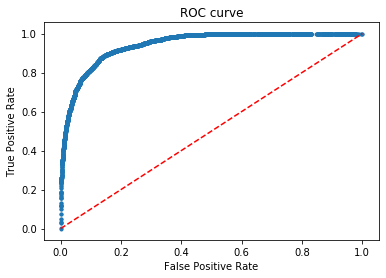

In [266]:
fpr, tpr, thresholds = roc_curve(df[["Revenue"]], y_proba)

# See the results in a table
pd.DataFrame({
    'False Positive Rate': fpr, 
    'True Positive Rate': tpr, 
    'Threshold': thresholds
})

# See the results on a plot. 
# This is the "Receiver Operating Characteristic" curve
plt.scatter(fpr, tpr, marker=".")
plt.plot([0,1], [0,1], linestyle="--", c="r")
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

---Class Label Distribution---
 0    10408
1     1908
Name: Revenue, dtype: int64

              precision    recall  f1-score   support

           0       0.96      0.94      0.95     10684
           1       0.65      0.76      0.70      1632

    accuracy                           0.91     12316
   macro avg       0.80      0.85      0.82     12316
weighted avg       0.92      0.91      0.92     12316



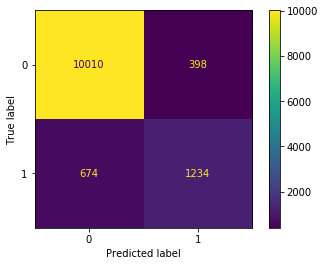

In [303]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

print("---Class Label Distribution---\n",df["Revenue"].value_counts())
print()
print(classification_report(g_model.predict(df.drop(columns="Revenue")), df[["Revenue"]]))
plot_confusion_matrix(g_model, df.drop(columns="Revenue"), df[["Revenue"]], values_format='.0f');

In [263]:
# Combine train and val and instead validate on test

pipe_final = make_pipeline(
    ce.OneHotEncoder(drop_invariant=True),
    StandardScaler(),
    SimpleImputer(strategy="mean"), 
    XGBClassifier(
        n_estimators=478,
        min_child_weight=1,
        max_depth=11,
        learning_rate=0.2,
        gamma=0.2,
        model_booster="gbtree"
    )
)

pipe_final.fit(training.drop(columns="Revenue"), training[["Revenue"]])
y_pred = pipe_final.predict(test.drop(columns="Revenue"))
print('Accuracy', accuracy_score(test[["Revenue"]], y_pred))

Accuracy 0.8937966872361156


In [264]:
y_proba = pipe_final.predict_proba(test.drop(columns="Revenue"))[:,-1]
roc_auc_score(test[["Revenue"]], y_proba)

0.91706265950291

training shape after encoding (9237, 28)


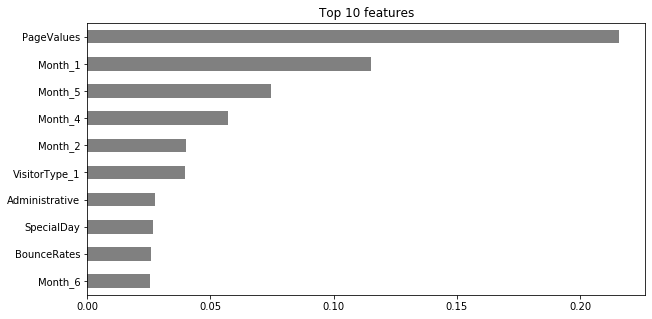

In [248]:
encoder_merge = pipe_final.named_steps['onehotencoder']
encoded_merge = encoder_merge.transform(training.drop(columns="Revenue"))
print('training shape after encoding', encoded_merge.shape)

model_merge = pipe_final.named_steps['xgbclassifier']
importances_merge = pd.Series(model_merge.feature_importances_, encoded_merge.columns)

n = 10
plt.figure(figsize=(10, n/2))
plt.title(f'Top {n} features')
importances_merge.sort_values()[-n:].plot.barh(color='grey');

In [324]:
import eli5
from eli5.sklearn import PermutationImportance

processor = make_pipeline(
    ce.OneHotEncoder(drop_invariant=True),
    StandardScaler(),
    SimpleImputer(strategy='median')
)


model = XGBClassifier(n_estimators=478,
                      min_child_weight=1,
                      max_depth=11,
                      learning_rate=0.2,
                      gamma=0.2,
                      model_booster="gbtree"
                      )

# Fit transform on data
permute_train = processor.fit_transform(training.drop(columns="Revenue"))
permute_test = processor.transform(test.drop(columns="Revenue"))

#Pull out column names after encoding
col_list = pipe_final.named_steps['onehotencoder']
col_list = col_list.transform(training.drop(columns="Revenue"))

model.fit(permute_train, training[["Revenue"]])

permuter = PermutationImportance(
    model, 
    scoring='accuracy', 
    n_iter=30, 
    random_state=42
)

permuter.fit(permute_test, test[["Revenue"]])

eli5.show_weights(
    permuter,
    top=None,
    feature_names = col_list.columns.tolist()
)

Weight,Feature
0.1382 ± 0.0098,PageValues
0.0058 ± 0.0044,ProductRelated
0.0039 ± 0.0063,ExitRates
0.0036 ± 0.0031,Month_1
0.0035 ± 0.0040,Administrative
0.0033 ± 0.0030,ProductRelated_Duration
0.0032 ± 0.0037,BounceRates
0.0018 ± 0.0030,TrafficType
0.0009 ± 0.0017,Informational_Duration
0.0008 ± 0.0011,SpecialDay


(0.0001, 1)

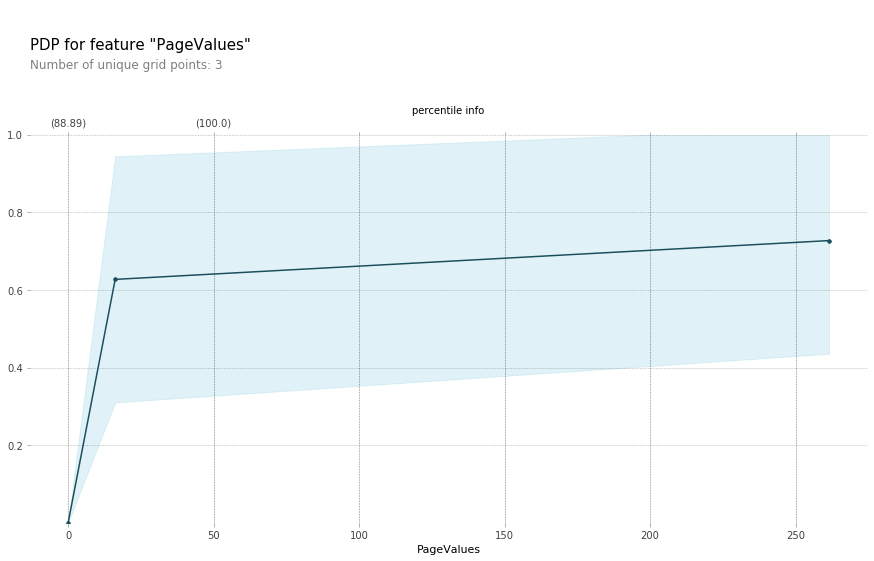

In [325]:
feature = "PageValues"

isolated = pdp_isolate(
    model = pipe_final,
    dataset = test.drop(columns="Revenue"), #Must use dataset that doesnt have NaN value present
    model_features = list(test.drop(columns="Revenue").columns),
    feature = feature
)

pdp_plot(isolated,
         feature_name=feature, 
         frac_to_plot=50,
        show_percentile=True)
plt.ylim(0.0001,1)

In [338]:
import shap

row = test.drop(columns="Revenue").loc[[6257]]

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=col_list.columns,
    link="logit"
)